In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [6]:
files = ['Consumable', 'Non-Consumable']
address = 'D:/VIT/Meat-Quality-Assessment-and-Classification/Dataset/Fish/'

In [7]:
data = {}
for f in files:
    data[f]=[]
for col in files:
    os.chdir(address+col)
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpg'):
            data[col].append(i)

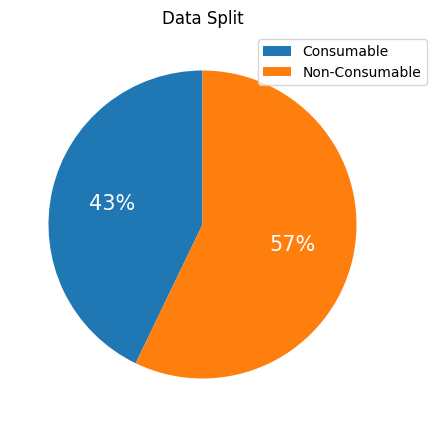

In [8]:
sizes = [len(data['Consumable']), len(data['Non-Consumable'])]
plt.figure(figsize=(10,5), dpi=100)
plt.pie(x=sizes,autopct='%1.0f%%',shadow=False, textprops={'color':"w","fontsize":15}, startangle=90)
plt.legend(files,bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

In [9]:
width = 100
height = 100

In [10]:
start = time.time()
image_data = []
image_target = []
for title in files:
    os.chdir(address+title)
    counter = 0
    for i in data[title]:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_data.append(cv2.resize(img,(width, height)))
        image_target.append(title)
        counter += 1
    clear_output(wait=True)
calculate_time = time.time() - start    
print("Calculate Time",round(calculate_time,5))

Calculate Time 34.62666


In [11]:
image_data = np.array(image_data)
size = image_data.shape[0]
image_data.shape

(140, 100, 100, 3)

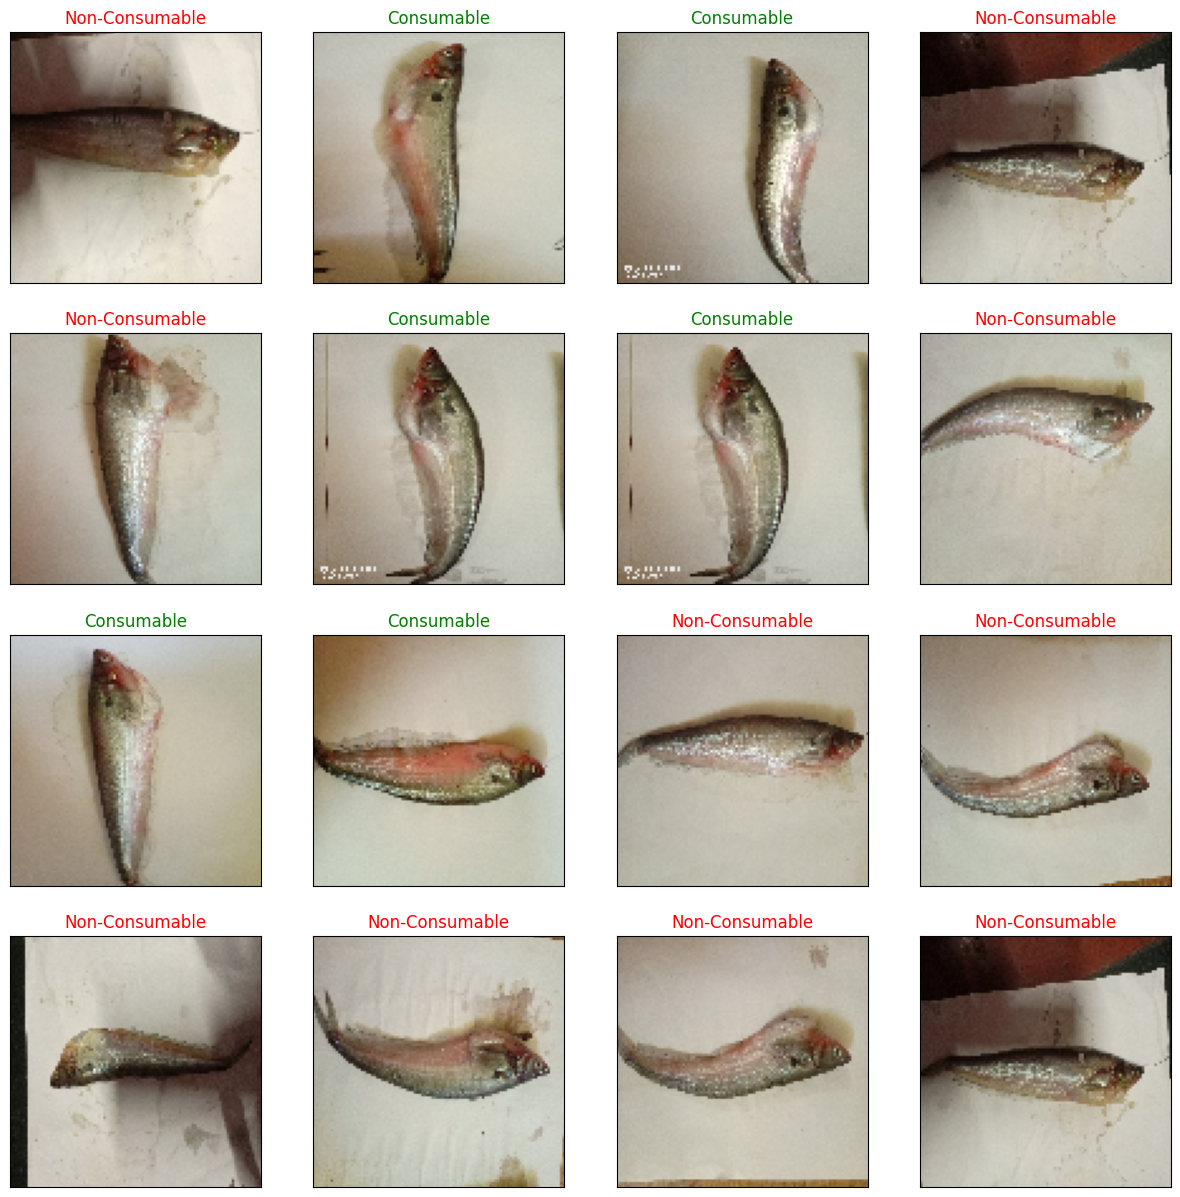

In [12]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='Consumable':
        c='green'
    else:
        c='red'
    plt.title(image_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [13]:
labels = LabelEncoder()
labels.fit(image_target)

LabelEncoder()

In [14]:
X = image_data / 255.0
y = labels.transform(image_target)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=123)

In [15]:
def resnet_model(input_shape=(width,height,3)):
    resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    x = layers.Flatten()(resnet.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=resnet.input, outputs=predictions)
    for layer in resnet.layers:
        layer.trainable = False
    return model
model = resnet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5694 - loss: 1.8740 - val_accuracy: 0.5238 - val_loss: 1.9756
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 0.4258 - loss: 1.8270 - val_accuracy: 0.5238 - val_loss: 0.6944
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.6211 - loss: 0.9161 - val_accuracy: 0.4762 - val_loss: 0.8020
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.3985 - loss: 0.9212 - val_accuracy: 0.5238 - val_loss: 1.1500
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - accuracy: 0.6138 - loss: 1.2244 - val_accuracy: 0.6190 - val_loss: 0.6605
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - accuracy: 0.4825 - loss: 1.0841 - val_accuracy: 0.4762 - val_loss: 1.2492
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.4667 - loss: 1.0215 - val_accuracy: 0.5238 - val_loss: 1.5249
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - accuracy: 0.6055 - loss: 1.4107 - val_accuracy: 0.5238 - val_loss: 0

2/2 - 1s - 267ms/step - accuracy: 0.5238 - loss: 1.1939


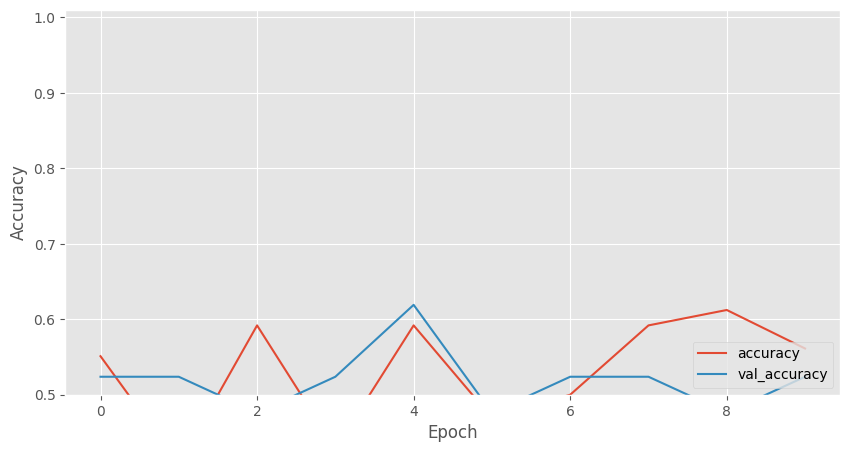

In [16]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.01])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [17]:
result=model.evaluate(test_images, test_labels)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.5055 - loss: 1.2340


In [18]:
for i in range(len(model.metrics_names)):
    print(model.metrics_names[i],":",result[i])

loss : 1.1938560009002686
compile_metrics : 0.523809552192688


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


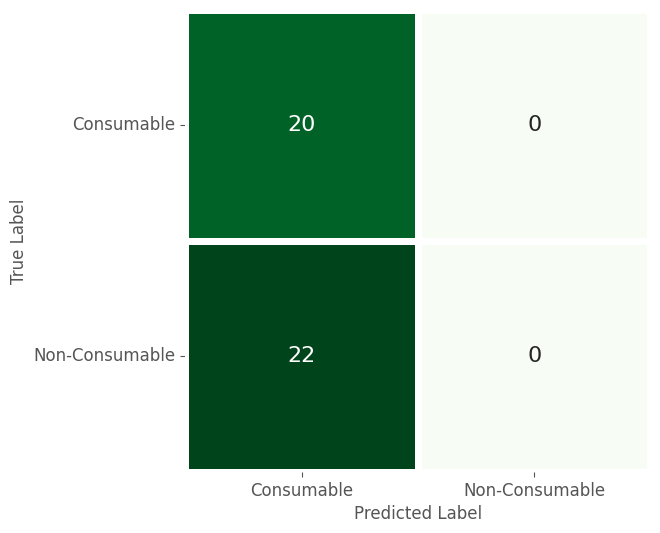

In [19]:
y_pred = model.predict(test_images)
def toClass(pred):
    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index
    return class_
cm = confusion_matrix(test_labels,toClass(y_pred))
df1 = pd.DataFrame(columns=["Consumable","Non-Consumable"], index= ["Consumable","Non-Consumable"], data= cm )
f,ax = plt.subplots(figsize=(6,6))
sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.show()

In [22]:
files = ['Consumable', 'Non-Consumable']
address = 'D:/VIT/Meat-Quality-Assessment-and-Classification/Dataset/Fish/'

In [23]:
data = {}
for f in files:
    data[f]=[]
for col in files:
    os.chdir(address+col)
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpg'):
            data[col].append(i)

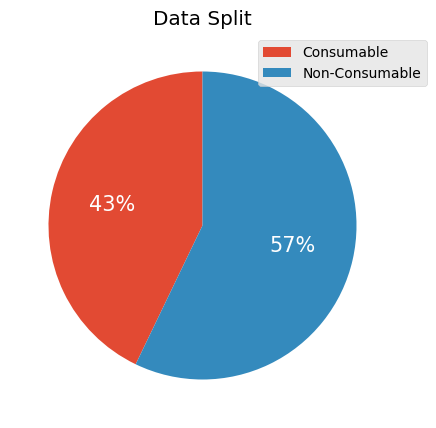

In [24]:
sizes = [len(data['Consumable']), len(data['Non-Consumable'])]
plt.figure(figsize=(10,5), dpi=100)
plt.pie(x=sizes,autopct='%1.0f%%',shadow=False, textprops={'color':"w","fontsize":15}, startangle=90)
plt.legend(files,bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

In [25]:
width = 100
height = 100

In [26]:
start = time.time()
image_data = []
image_target = []
for title in files:
    os.chdir(address+title)
    counter = 0
    for i in data[title]:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        image_data.append(cv2.resize(img,(width, height)))
        image_target.append(title)
        counter += 1
    clear_output(wait=True)
calculate_time = time.time() - start    
print("Calculate Time",round(calculate_time,5))

Calculate Time 36.09629


In [27]:
image_data = np.array(image_data)
size = image_data.shape[0]
image_data.shape

(140, 100, 100, 3)

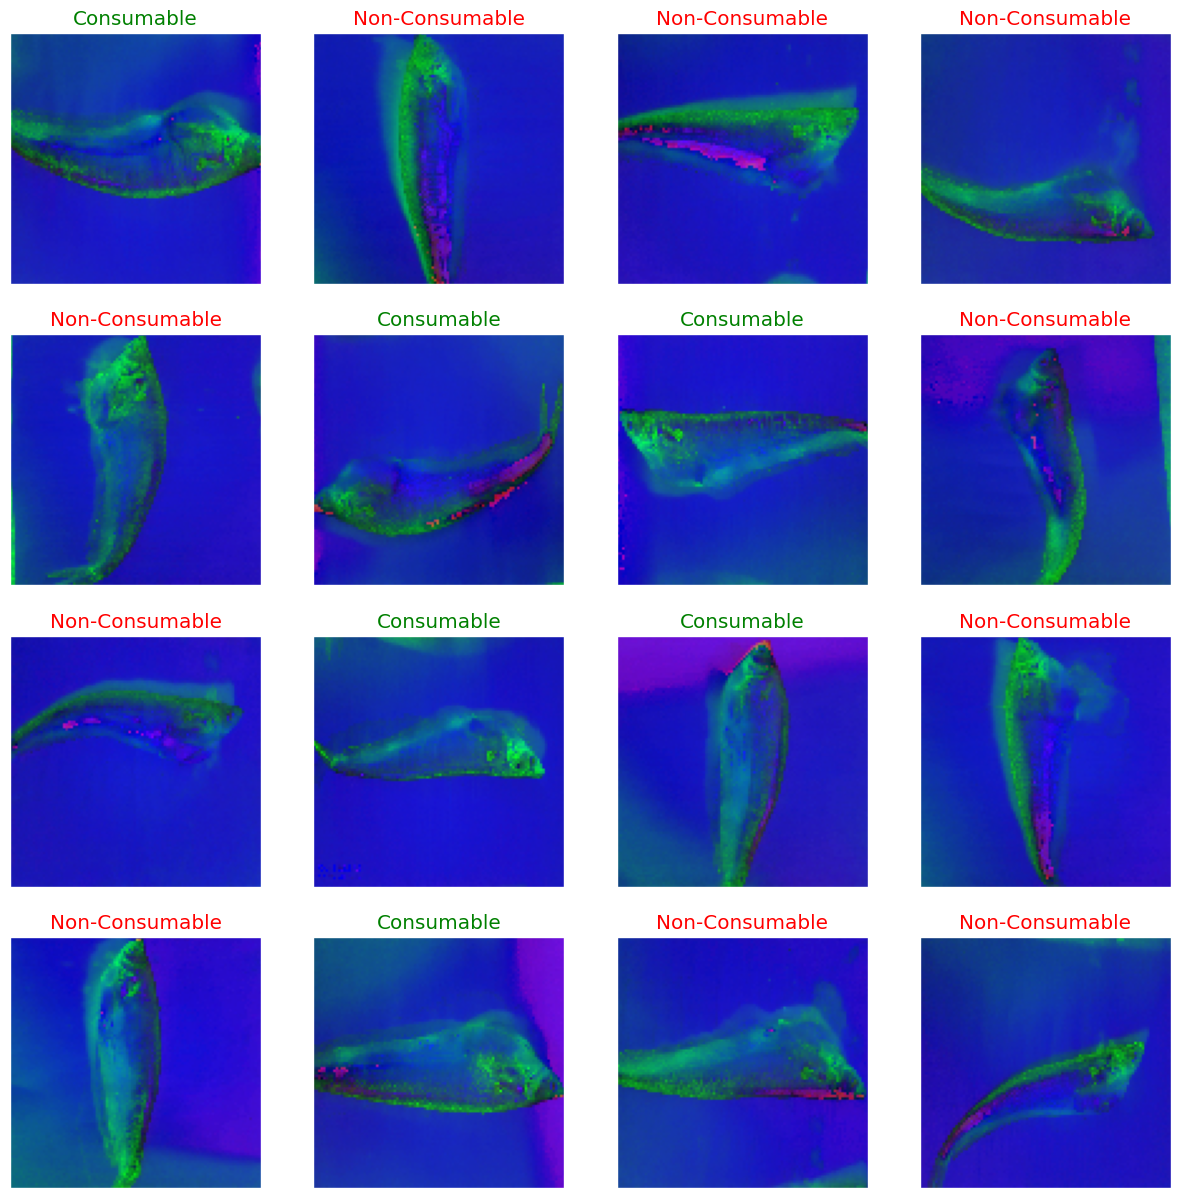

In [28]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='Consumable':
        c='green'
    else:
        c='red'
    plt.title(image_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [29]:
labels = LabelEncoder()
labels.fit(image_target)

LabelEncoder()

In [30]:
X = image_data / 360.0
y = labels.transform(image_target)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=123)

In [31]:
def resnet_model(input_shape=(width,height,3)):
    resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    x = layers.Flatten()(resnet.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=resnet.input, outputs=predictions)
    for layer in resnet.layers:
        layer.trainable = False
    return model
model = resnet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4693 - loss: 1.9983 - val_accuracy: 0.7619 - val_loss: 0.6593
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - accuracy: 0.6620 - loss: 0.6522 - val_accuracy: 0.8095 - val_loss: 0.5706
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 0.8667 - loss: 0.3012 - val_accuracy: 0.6667 - val_loss: 0.8948
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.8572 - loss: 0.3310 - val_accuracy: 0.6905 - val_loss: 1.0737
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step - accuracy: 0.9037 - loss: 0.2911 - val_accuracy: 0.8095 - val_loss: 0.4307
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step - accuracy: 0.9845 - loss: 0.0624 - val_accuracy: 0.6905 - val_loss: 0.7851
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 0.9689 - loss: 0.0634 - val_accuracy: 0.8571 - val_loss: 0.3599
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 424ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.8333 - val_loss: 0

2/2 - 1s - 273ms/step - accuracy: 0.8333 - loss: 0.3608


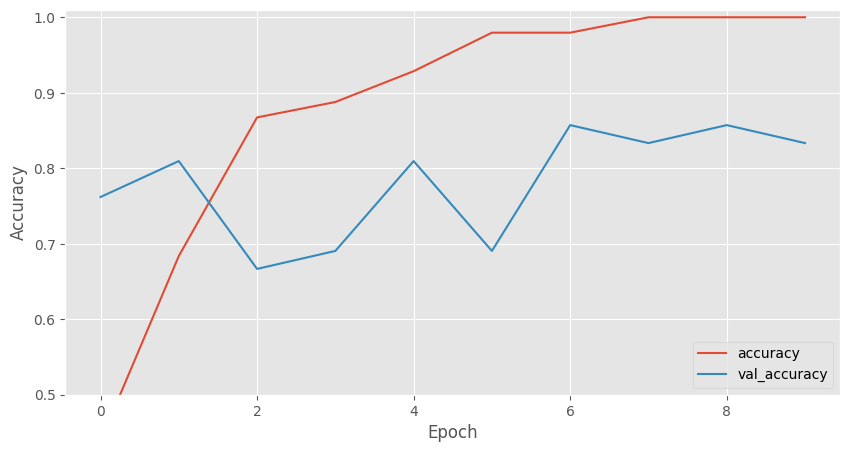

In [32]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.01])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [33]:
result=model.evaluate(test_images, test_labels)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.8368 - loss: 0.3569


In [34]:
for i in range(len(model.metrics_names)):
    print(model.metrics_names[i],":",result[i])

loss : 0.360772043466568
compile_metrics : 0.8333333134651184


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


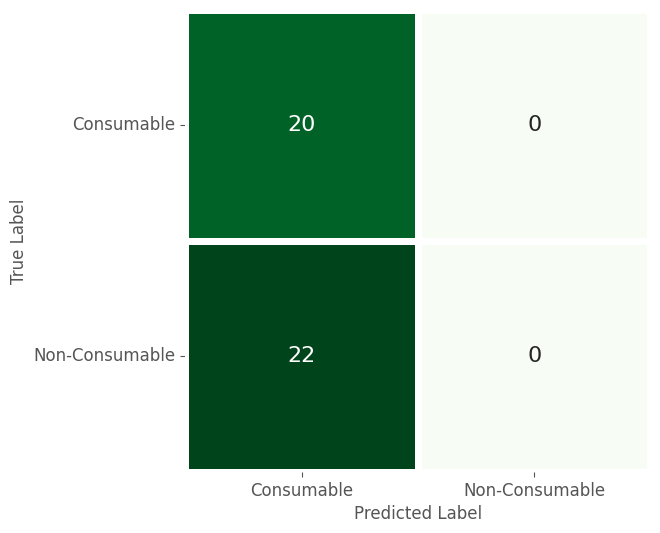

In [35]:
y_pred = model.predict(test_images)
def toClass(pred):
    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index
    return class_
cm = confusion_matrix(test_labels,toClass(y_pred))
df1 = pd.DataFrame(columns=["Consumable","Non-Consumable"], index= ["Consumable","Non-Consumable"], data= cm )
f,ax = plt.subplots(figsize=(6,6))
sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.show()